In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
data=pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")

In [3]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data.columns.values]

In [4]:
# Data Quality Checking
col = []
missing = []
level = [] 
for name in data.columns:
    
    # Missing
    missper = data[name].isnull().sum() / data.shape[0]
    missing.append(round(missper, 4))

    # Leveling
    lel = data[name].dropna()
    level.append(len(list(set(lel))))

    # Columns
    col.append(name)

summary = pd.concat([pd.DataFrame(col, columns=['name']), 
                     pd.DataFrame(missing, columns=['Missing Percentage']), 
                     pd.DataFrame(level, columns=['Level'])], axis=1)

drop_col = summary['name'][(summary['Level'] <= 1) | (summary['Missing Percentage'] >= 0.8)]
data.drop(columns=drop_col, inplace=True)
print(">>>> Data Shape : {}".format(data.shape))

>>>> Data Shape : (532, 22)


In [5]:
drop_col

10    zprior
Name: name, dtype: object

In [6]:
summary

,name,Missing Percentage,Level
0,censor,0.0,2
1,event,0.0,358
2,age,0.0,52
3,wtkg,0.0,312
4,hemo,0.0,2
5,homo,0.0,2
6,drugs,0.0,2
7,karnof,0.0,4
8,oprior,0.0,2
9,z30,0.0,2


In [7]:
data.shape

(532, 22)

In [8]:
# X's & Y Split
Y = data['censor']
X = data.drop(columns=['censor'])

In [9]:
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2021)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))
print(">>>> # of Train data Y : {}".format(Counter(Y.iloc[train_idx])))
print(">>>> # of valid data Y : {}".format(Counter(Y.iloc[valid_idx])))

>>>> # of Train data : 372
>>>> # of valid data : 160
>>>> # of Train data Y : Counter({0: 241, 1: 131})
>>>> # of valid data Y : Counter({0: 110, 1: 50})


In [10]:
# n_estimators
n_tree = [5, 10, 20]
# learning_rate
l_rate = [0.1, 0.3]
# max_depth
m_depth = [3, 5]
# reg_alpha
L1_norm = [0.1, 0.3, 0.5]

# Modeling
save_n = []
save_l = []
save_m = []
save_L1 = []
f1_score_ = []

cnt = 0

for n in n_tree:
    for l in l_rate:
        for m in m_depth:
            for L1 in L1_norm:
                
                print(">>> {} <<<".format(cnt))
                cnt +=1
                print("n_estimators : {}, learning_rate : {}, max_depth : {}, reg_alpha : {}".format(n, l, m, L1))
                model = XGBClassifier(n_estimators=n, learning_rate=l, 
                                      max_depth=m, reg_alpha=L1, objective='binary:logistic', random_state=119)
                model.fit(X.iloc[train_idx], Y.iloc[train_idx])
                
                
                # Train Acc
                y_pre_train = model.predict(X.iloc[train_idx])
                cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
                print("Train Confusion Matrix")
                print(cm_train)
                print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
                print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

                # Test Acc
                y_pre_test = model.predict(X.iloc[valid_idx])
                cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
                print("Test Confusion Matrix")
                print(cm_test)
                print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
                print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))
                print("-----------------------------------------------------------------------")
                print("-----------------------------------------------------------------------")
                save_n.append(n)
                save_l.append(l)
                save_m.append(m)
                save_L1.append(L1)
                f1_score_.append(f1_score(Y.iloc[valid_idx], y_pre_test))
                
                # Model 저장
                #import joblib
                #joblib.dump(model, './XGBoost_model/Result_{}_{}_{}_{}_{}.pkl'.format(n, l, m, L1, round(f1_score_[-1], 4)))
                #gc.collect()

>>> 0 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.1
Train Confusion Matrix
[[238   3]
 [ 60  71]]
Train Acc : 0.8306451612903226
Train F1-Score : 0.6926829268292682
Test Confusion Matrix
[[105   5]
 [ 19  31]]
TesT Acc : 0.85
Test F1-Score : 0.7209302325581396
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.3
Train Confusion Matrix
[[238   3]
 [ 60  71]]
Train Acc : 0.8306451612903226
Train F1-Score : 0.6926829268292682
Test Confusion Matrix
[[105   5]
 [ 19  31]]
TesT Acc : 0.85
Test F1-Score : 0.7209302325581396
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.5
Train Confusion Matrix
[[238   3]
 [ 60  71]]
Train Ac

In [11]:
print(">>> {} <<<\nBest Test f1-score : {}\nBest n_estimators : {}\nBest Learning Rate : {}\nBest Max_depth : {}\nBest L1-norm : {}".format(np.argmax(f1_score_),
                                                                                                                                            f1_score_[np.argmax(f1_score_)], 
                                                                                                                                            save_n[np.argmax(f1_score_)],
                                                                                                                                            save_l[np.argmax(f1_score_)],
                                                                                                                                            save_m[np.argmax(f1_score_)],
                                                                                                                                            save_L1[np.argmax(f1_score_)]))

>>> 24 <<<
Best Test f1-score : 0.8521739130434782
Best n_estimators : 20
Best Learning Rate : 0.1
Best Max_depth : 3
Best L1-norm : 0.1


In [12]:
best_model = XGBClassifier(n_estimators=save_n[np.argmax(f1_score_)], learning_rate=save_l[np.argmax(f1_score_)], 
                           max_depth=save_m[np.argmax(f1_score_)], reg_alpha=save_L1[np.argmax(f1_score_)], objective='binary:logistic', 
                           random_state=119)
best_model.fit(X.iloc[train_idx], Y.iloc[train_idx])

# Train Acc
y_pre_train = best_model.predict(X.iloc[train_idx])
cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

# Test Acc
y_pre_test = best_model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))

Train Confusion Matrix
[[227  14]
 [ 11 120]]
Train Acc : 0.9327956989247311
Train F1-Score : 0.9056603773584906
Test Confusion Matrix
[[94 16]
 [ 1 49]]
TesT Acc : 0.89375
Test F1-Score : 0.8521739130434782


In [13]:
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

       Score  Feature
0   0.384801    event
1   0.115327    cd496
2   0.089598  preanti
3   0.089240    cd420
4   0.078008     race
5   0.055997    cd820
6   0.048826     wtkg
7   0.032533      z30
8   0.027505     cd80
9   0.027451   karnof
10  0.026762     cd40
11  0.023951      age
12  0.000000  symptom
13  0.000000    strat
14  0.000000     str2
15  0.000000        r
16  0.000000   oprior
17  0.000000     homo
18  0.000000     hemo
19  0.000000   gender
20  0.000000    drugs


/var/folders/h2/dxdwtry542514hp51hkrx__h0000gn/T/ipykernel_18317/1100503309.py:4: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 40}` instead.

  sns.barplot(x="Score", y="Feature", data=feature_map_10.sort_values(by="Score", ascending=False), errwidth=40)


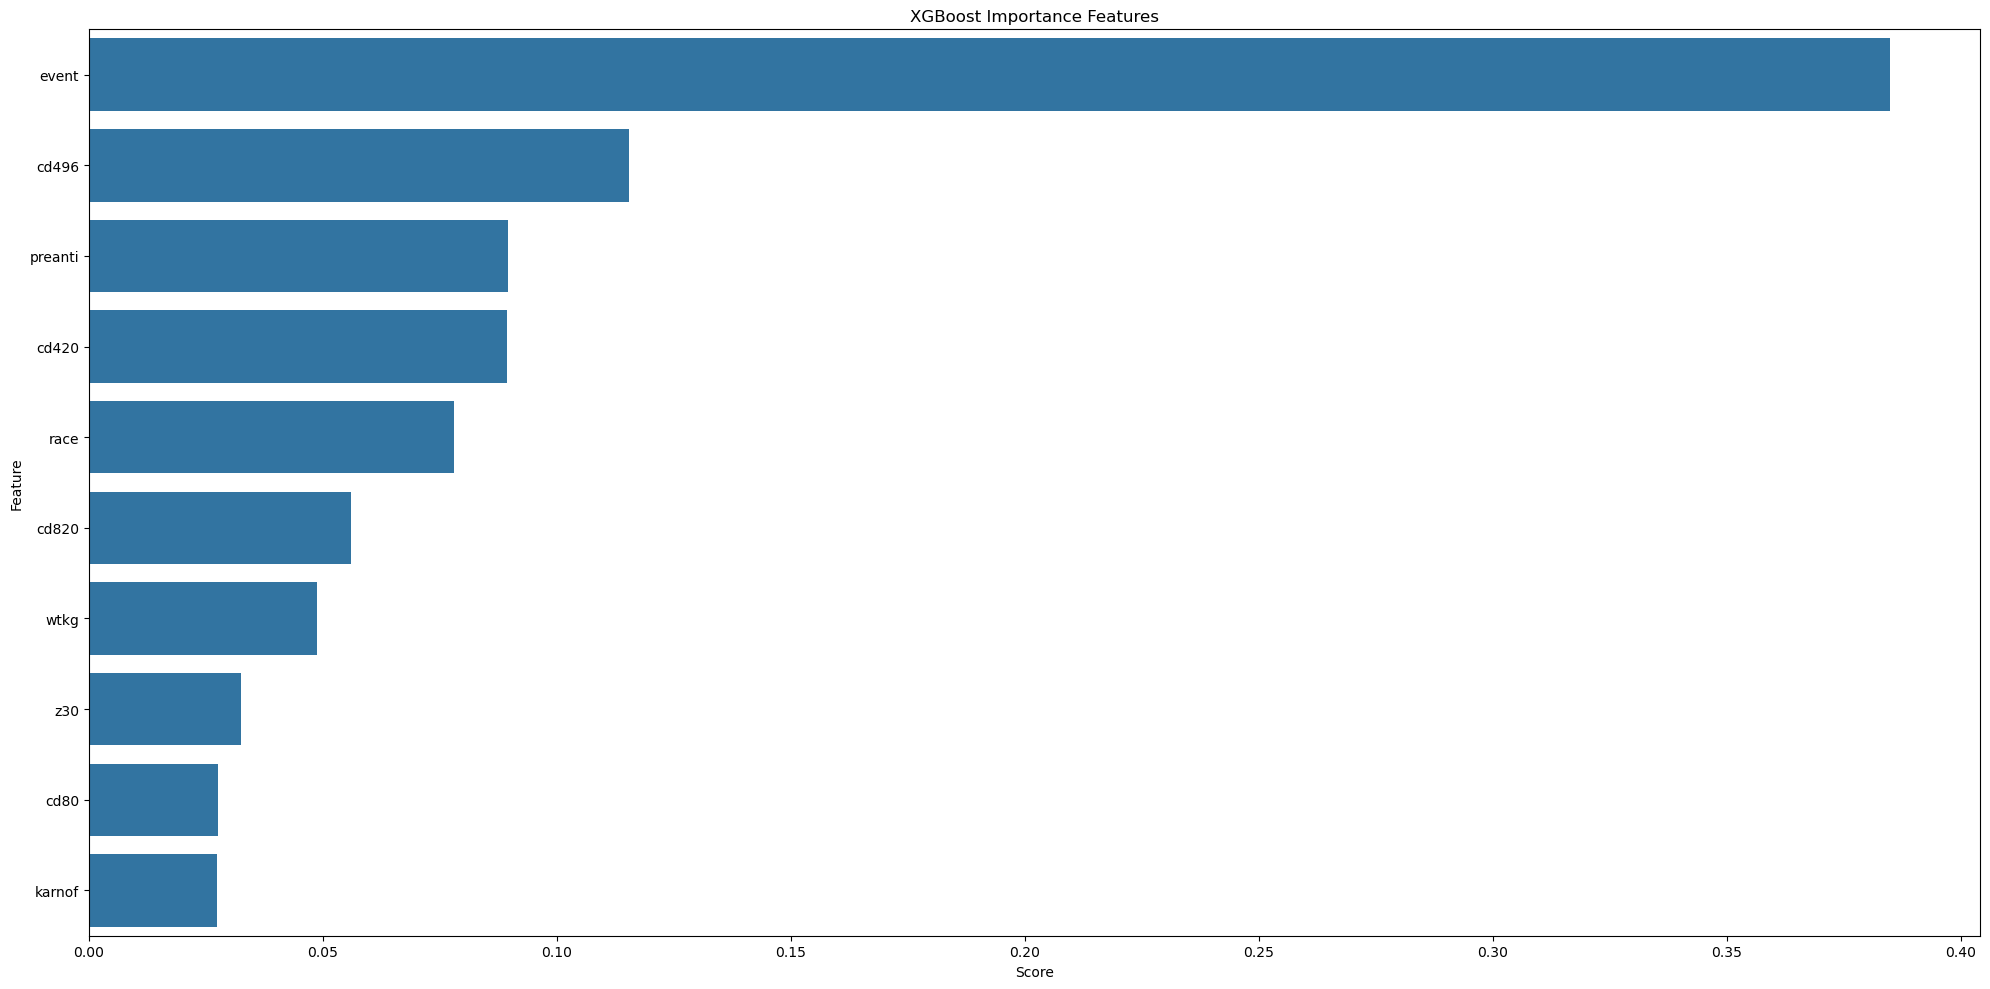

In [14]:
# Importance Score Top 10
feature_map_10 = feature_map.iloc[:10]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_10.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('XGBoost Importance Features')
plt.tight_layout()
plt.show()